# Utils

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
def set_seed(seed_value=42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

Define a basic network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def train(model, device, criterion, optimizer, train_loader):
    model.train()

    losses, accs = [], []
    correct = 0.

    for batch_idx, (data, target) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # prediction
        pred = output.argmax(dim=1, keepdim=True)
        correct = torch.eq(pred, target.view_as(pred)).float()
        acc = torch.mean(correct)

        losses.append(loss.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())

    ## print current epoch loss and acc

    loss_k = np.array(losses).mean()
    acc_k = np.array(accs).mean()

    return loss_k, acc_k

In [5]:
def test(model, device, criterion, test_loader):
    model.eval()  # configura il modello in evaluation mode

    losses, accs = [], []
    correct = 0.

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            ## Compute loss
            output = model(data)
            loss = criterion(output, target)

            ## Prediction
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = torch.eq(pred, target.view_as(pred)).float()
            # correct += pred.eq(target.view_as(pred)).sum().item()
            acc = torch.mean(correct)

            ## Update loss and accuracy
            losses.append(loss.detach().cpu().numpy())
            accs.append(acc.detach().cpu().numpy())

    loss_k = np.array(losses).mean()
    acc_k = np.array(accs).mean()

    return loss_k, acc_k

In [6]:
def test_class(model, device, criterion, test_loader):
    model.eval()  # configura il modello in evaluation mode

    # prepare to count predictions for each class
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    losses, accs = [], []
    correct = 0.

    with torch.no_grad():
        for data, target in test_loader:
            data, targets = data.to(device), target.to(device)

            ## Fit data
            output = model(data)

            ## Prediction
            preds = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for target, pred in zip(targets, preds):
                if target == pred:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Exercise 0

In [7]:
# without normalization
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
mean = torch.zeros(3)  # a mean for each channel, here 1
std = torch.zeros(3)  # a std for each channel, here 1
samples = 0

# simple because we only have one channel, that is greyscale
for X, y in trainloader:
    # width and height over one dimension
    X = torch.flatten(X, 2, 3)
    # compute mean and std over each channel then sum and store
    mean += X.mean(2).sum(0)
    std += X.std(2).sum(0)
    samples += X.size(0)

print(f"Samples {samples}")
mean /= samples
print(f"Mean {mean}")
std /= samples
print(f"Std {std}")

Samples 50000
Mean tensor([0.4914, 0.4822, 0.4465])
Std tensor([0.2023, 0.1994, 0.2010])


In [9]:
# normalize data correctly
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Exercise 1
Learning rate scheduler

In [10]:
max_epochs = 20

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
def simple_diagnostic(max_epochs, losses_train, accs_train):
    epochs_seq = np.arange(1, max_epochs + 1)
    # epoch_labels = 

    # plot only training loss and accuracy
    fig, ax = plt.subplots()
    # fig.suptitle("Training performance")
    fig.suptitle("Training loss and accuracy againts epochs")

    color = "tab:blue"
    ax.plot(epochs_seq, losses_train, label="loss", color=color)
    # ax.set_title("Training loss and accuracy againts epochs")
    ax.grid("both")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss", color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xticks(np.arange(1, max_epochs+1, step=2))
    ax.set_xticklabels(np.arange(1, max_epochs + 1, 2))

    color = "tab:red"
    ax_1 = ax.twinx()
    ax_1.plot(epochs_seq, accs_train, label="accuracy", color="tab:red")
    ax_1.set_ylabel("Accuracy", color="tab:red")
    ax_1.tick_params(axis="y", labelcolor=color)

In [14]:
def multiple_diagnostic(loss_acc_dict):
    # loss_acc_dict = {"Solver1": [loss, acc]...}

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    # fig.suptitle("CNN training performance over CIFAR10")

    for solver_name, perf in loss_acc_dict.items():

        # plot loss function performance
        axs[0].plot(perf[0], label=solver_name)
        axs[0].grid("both")
        axs[0].set_title("Loss against epochs")

        # plot accuracy performance
        axs[1].plot(perf[1], label=solver_name)
        axs[1].grid("both")
        axs[1].set_title("Accuracy against epochs")

    axs[0].legend()
    axs[1].legend()

In [13]:
es1_loss_acc = {}  # {"Solver1": [loss, acc]}

## Basic training

In [15]:
set_seed()
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses, accs = [], []
for epoch in range(max_epochs):
    loss_k, acc_k = train(model, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, learning rate: {get_lr(optimizer):.5f}, loss: {loss_k:.4f}, accuracy: {acc_k:.2f}")

es1_loss_acc["SGD"] = [losses, accs]

Epoch: 0, learning rate: 0.001, loss: 2.1795, accuracy: 0.19
Epoch: 1, learning rate: 0.001, loss: 1.7684, accuracy: 0.36
Epoch: 2, learning rate: 0.001, loss: 1.5635, accuracy: 0.43
Epoch: 3, learning rate: 0.001, loss: 1.4733, accuracy: 0.46
Epoch: 4, learning rate: 0.001, loss: 1.4033, accuracy: 0.49
Epoch: 5, learning rate: 0.001, loss: 1.3389, accuracy: 0.52
Epoch: 6, learning rate: 0.001, loss: 1.2755, accuracy: 0.54
Epoch: 7, learning rate: 0.001, loss: 1.2212, accuracy: 0.57
Epoch: 8, learning rate: 0.001, loss: 1.1793, accuracy: 0.58
Epoch: 9, learning rate: 0.001, loss: 1.1409, accuracy: 0.60
Epoch: 10, learning rate: 0.001, loss: 1.1040, accuracy: 0.61
Epoch: 11, learning rate: 0.001, loss: 1.0738, accuracy: 0.62
Epoch: 12, learning rate: 0.001, loss: 1.0434, accuracy: 0.63
Epoch: 13, learning rate: 0.001, loss: 1.0148, accuracy: 0.64
Epoch: 14, learning rate: 0.001, loss: 0.9870, accuracy: 0.65
Epoch: 15, learning rate: 0.001, loss: 0.9649, accuracy: 0.66
Epoch: 16, learnin

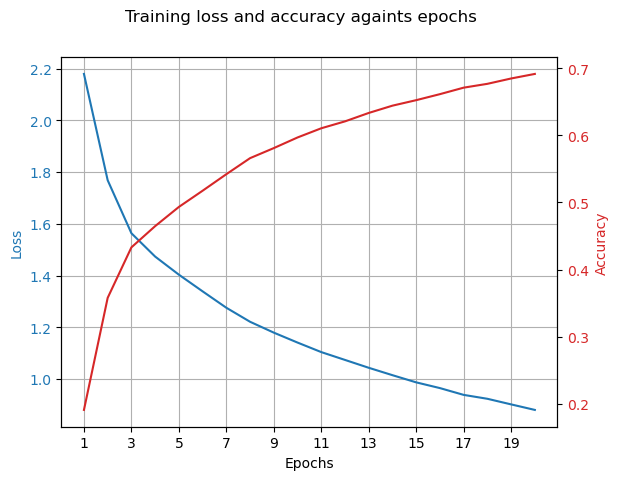

In [18]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd.pdf")

## Multi-step scheduler

In [20]:
from torch.optim.lr_scheduler import MultiStepLR

set_seed()
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[2, 5], gamma=0.1)

losses, accs = [], []
for epoch in range(max_epochs):
    loss_k, acc_k = train(model, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, learning rate: {get_lr(optimizer):.5f}, loss: {loss_k:.4f}, accuracy: {acc_k:.2f}")
    scheduler.step()

es1_loss_acc["SGD-Step"] = [losses, accs]

Epoch: 0, learning rate: 0.08, loss: 1.9566, accuracy: 0.26
Epoch: 1, learning rate: 0.08, loss: 1.8920, accuracy: 0.30
Epoch: 2, learning rate: 0.008, loss: 1.6702, accuracy: 0.38
Epoch: 3, learning rate: 0.008, loss: 1.5365, accuracy: 0.44
Epoch: 4, learning rate: 0.008, loss: 1.4481, accuracy: 0.47
Epoch: 5, learning rate: 0.0008, loss: 1.3529, accuracy: 0.51
Epoch: 6, learning rate: 0.0008, loss: 1.3347, accuracy: 0.51
Epoch: 7, learning rate: 0.0008, loss: 1.3233, accuracy: 0.52
Epoch: 8, learning rate: 0.0008, loss: 1.3132, accuracy: 0.52
Epoch: 9, learning rate: 0.0008, loss: 1.3035, accuracy: 0.53
Epoch: 10, learning rate: 0.0008, loss: 1.2939, accuracy: 0.53
Epoch: 11, learning rate: 0.0008, loss: 1.2851, accuracy: 0.53
Epoch: 12, learning rate: 0.0008, loss: 1.2761, accuracy: 0.54
Epoch: 13, learning rate: 0.0008, loss: 1.2676, accuracy: 0.54
Epoch: 14, learning rate: 0.0008, loss: 1.2589, accuracy: 0.54
Epoch: 15, learning rate: 0.0008, loss: 1.2512, accuracy: 0.55
Epoch: 16

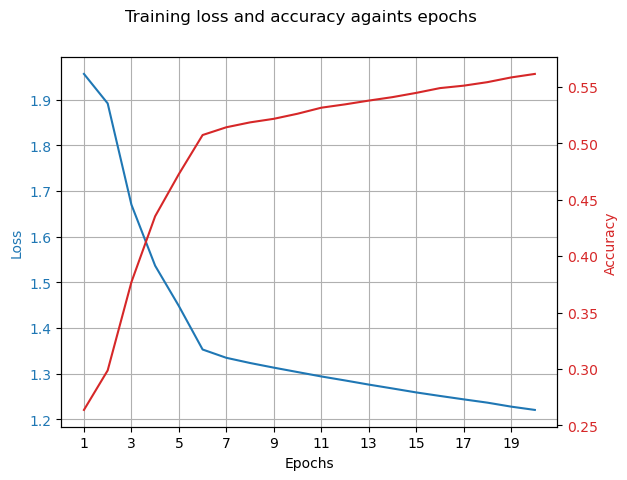

In [21]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-step.pdf")

## Exponential scheduler

In [24]:
from torch.optim.lr_scheduler import ExponentialLR

set_seed()
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ExponentialLR(optimizer, 0.95)

losses, accs = [], []
for epoch in range(max_epochs):
    loss_k, acc_k = train(model, device, criterion, optimizer, trainloader)
    losses.append(loss_k)
    accs.append(acc_k)
    print(f"Epoch: {epoch}, learning rate: {get_lr(optimizer):.5f}, loss: {loss_k:.4f}, accuracy: {acc_k:.2f}")
    scheduler.step()

es1_loss_acc["SGD-Exp"] = [losses, accs]

Epoch: 0, learning rate: 0.01000, loss: 1.6839, accuracy: 0.38
Epoch: 1, learning rate: 0.00950, loss: 1.3278, accuracy: 0.52
Epoch: 2, learning rate: 0.00903, loss: 1.1803, accuracy: 0.58
Epoch: 3, learning rate: 0.00857, loss: 1.0860, accuracy: 0.62
Epoch: 4, learning rate: 0.00815, loss: 1.0055, accuracy: 0.65
Epoch: 5, learning rate: 0.00774, loss: 0.9346, accuracy: 0.67
Epoch: 6, learning rate: 0.00735, loss: 0.8864, accuracy: 0.69
Epoch: 7, learning rate: 0.00698, loss: 0.8381, accuracy: 0.71
Epoch: 8, learning rate: 0.00663, loss: 0.7906, accuracy: 0.72
Epoch: 9, learning rate: 0.00630, loss: 0.7454, accuracy: 0.74
Epoch: 10, learning rate: 0.00599, loss: 0.7065, accuracy: 0.75
Epoch: 11, learning rate: 0.00569, loss: 0.6657, accuracy: 0.76
Epoch: 12, learning rate: 0.00540, loss: 0.6294, accuracy: 0.77
Epoch: 13, learning rate: 0.00513, loss: 0.5985, accuracy: 0.78
Epoch: 14, learning rate: 0.00488, loss: 0.5605, accuracy: 0.80
Epoch: 15, learning rate: 0.00463, loss: 0.5319, a

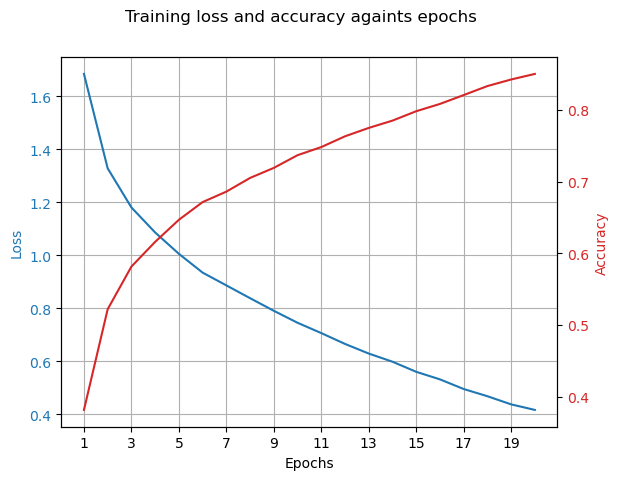

In [25]:
simple_diagnostic(max_epochs, losses, accs)
plt.savefig("./plots/es1-sgd-exp.pdf")

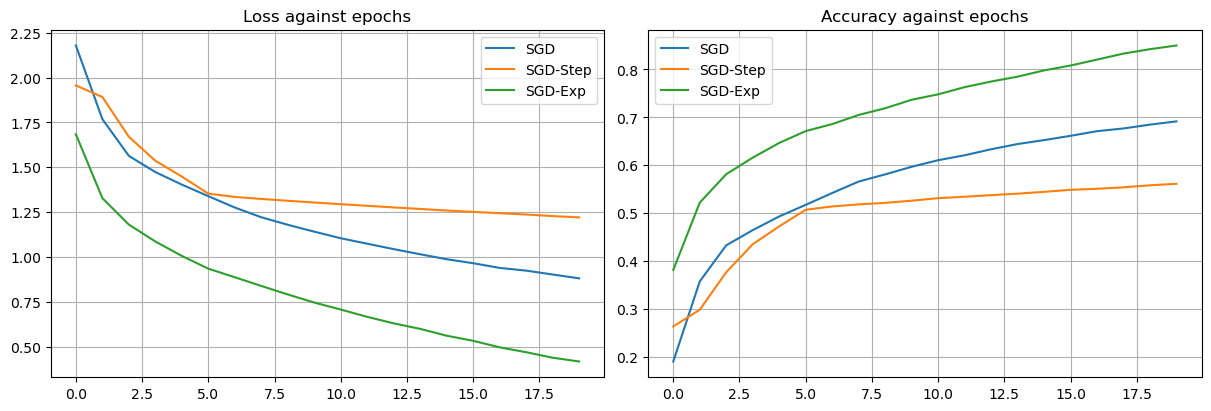

In [27]:
multiple_diagnostic(es1_loss_acc)
plt.savefig("./plots/es1-diagnostic.pdf")

# Excercise 2